In [7]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.fig_utils import full_dist_to_print, dataset_to_print, dist_to_color, dist_to_print, full_dist_to_color, plot_edges_on_scatter, find_best_full_dists_by_auc
from utils.io_utils import load_multiple_res, dist_kwargs_to_str
from utils.pd_utils import compute_outlier_scores, filter_dgms
from utils.pd_utils import get_persistent_feature_id
from utils.dist_utils import get_dist
import os
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [8]:
style_file = "utils.style"
plt.style.use(style_file)

In [9]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Bounding cube with fixed outliers

In [10]:
# get data
dataset = "toy_circle"

n = 1000

sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
sigma_max = sigmas.max()
seeds = [0, 1, 2]

nbs_outliers = [0, 50, 100, 200]

In [11]:
# distances to investigate
distances = {
    "euclidean": [{}],
    "fermat": [
               {"p": 2},
               {"p": 3},
               {"p": 5},
               {"p": 7}
               ],
    "dtm": [
            {"k": 4, "p_dtm": 2, "p_radius": 1},
            {"k": 4, "p_dtm": np.inf, "p_radius": 1},
            {"k": 15, "p_dtm": 2, "p_radius": 1},
            {"k": 15, "p_dtm": np.inf, "p_radius": 1},
            {"k": 100, "p_dtm": 2, "p_radius": 1},
            {"k": 100, "p_dtm": np.inf, "p_radius": 1},
            {"k": 4, "p_dtm": 2, "p_radius": 2},
            {"k": 4, "p_dtm": np.inf, "p_radius": 2},
            {"k": 15, "p_dtm": 2, "p_radius": 2},
            {"k": 15, "p_dtm": np.inf, "p_radius": 2},
            {"k": 100, "p_dtm": 2, "p_radius": 2},
            {"k": 100, "p_dtm": np.inf, "p_radius": 2},
            {"k": 4, "p_dtm": 2, "p_radius": np.inf},
            {"k": 4, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 15, "p_dtm": 2, "p_radius": np.inf},
            {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 100, "p_dtm": 2, "p_radius": np.inf},
            {"k": 100, "p_dtm": np.inf, "p_radius": np.inf},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    ],
    "diffusion": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
}

In [12]:
# load PH results
all_res_50 = load_multiple_res(datasets=dataset, n=n, embd_dims=50, sigmas=sigmas, seeds=seeds, nbs_outliers=nbs_outliers, distances=distances, root_path=root_path, rforsigma=sigma_max)
all_res_2 = load_multiple_res(datasets=dataset, n=n, embd_dims=2, sigmas=sigmas, seeds=seeds, nbs_outliers=nbs_outliers, distances=distances, root_path=root_path, rforsigma=sigma_max)

Done with toy_circle 50 euclidean n_outliers=0, perturbation=None
Done with toy_circle 50 euclidean n_outliers=50, perturbation=None
Done with toy_circle 50 euclidean n_outliers=100, perturbation=None
Done with toy_circle 50 euclidean n_outliers=200, perturbation=None
Done with toy_circle 50 fermat_p_2 n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_2 n_outliers=50, perturbation=None
Done with toy_circle 50 fermat_p_2 n_outliers=100, perturbation=None
Done with toy_circle 50 fermat_p_2 n_outliers=200, perturbation=None
Done with toy_circle 50 fermat_p_3 n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_3 n_outliers=50, perturbation=None
Done with toy_circle 50 fermat_p_3 n_outliers=100, perturbation=None
Done with toy_circle 50 fermat_p_3 n_outliers=200, perturbation=None
Done with toy_circle 50 fermat_p_5 n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_5 n_outliers=50, perturbation=None
Done with toy_circle 50 fermat_p_5 n_outliers=100,

In [13]:
# thresholding
dob = 1.25
all_res_50 = filter_dgms(dgms=all_res_50, dob=dob, dim=1, binary=True)
all_res_2 = filter_dgms(dgms=all_res_2, dob=dob, dim=1, binary=True)

In [14]:
# compute detection scores
outlier_scores = {
    2: compute_outlier_scores(all_res_2, dim=1, n_features=1),
    50: compute_outlier_scores(all_res_50, dim=1, n_features=1)
                  }

In [15]:
# select best hyperparameters per outlier / dimension
best_full_dists = {
    embd_dim: find_best_full_dists_by_auc(outlier_scores[embd_dim], distance_level=0) for embd_dim in outlier_scores
}

In [16]:
# print best hyperparameters
for embd_dim in best_full_dists:
    for dist in best_full_dists[embd_dim]:
        for i, n_outliers in enumerate(nbs_outliers):
            print(embd_dim, n_outliers,  full_dist_to_print[best_full_dists[embd_dim][dist][i]].replace("\n", " "))
    print("\n")

2 0 Euclidean
2 50 Euclidean
2 100 Euclidean
2 200 Euclidean
2 0 Fermat $p=2$
2 50 Fermat $p=7$
2 100 Fermat $p=7$
2 200 Fermat $p=7$
2 0 DTM $k=100, p=\infty, \xi=2$
2 50 DTM $k=100, p=\infty, \xi=2$
2 100 DTM $k=100, p=\infty, \xi=2$
2 200 DTM $k=100, p=\infty, \xi=2$
2 0 Effective resistance $k=100$
2 50 Effective resistance $k=100$
2 100 Effective resistance $k=100$
2 200 Effective resistance $k=100$
2 0 Diffusion $k=100, t=64$
2 50 Diffusion $k=100, t=64$
2 100 Diffusion $k=100, t=64$
2 200 Diffusion $k=100, t=64$


50 0 Euclidean
50 50 Euclidean
50 100 Euclidean
50 200 Euclidean
50 0 Fermat $p=3$
50 50 Fermat $p=2$
50 100 Fermat $p=2$
50 200 Fermat $p=2$
50 0 DTM $k=4, p=2, \xi=1$
50 50 DTM $k=4, p=2, \xi=1$
50 100 DTM $k=4, p=2, \xi=1$
50 200 DTM $k=4, p=2, \xi=1$
50 0 Effective resistance $k=100$
50 50 Effective resistance $k=100$
50 100 Effective resistance $k=100$
50 200 Effective resistance $k=100$
50 0 Diffusion $k=15, t=8$
50 50 Diffusion $k=15, t=8$
50 100 Diffusion $k=15

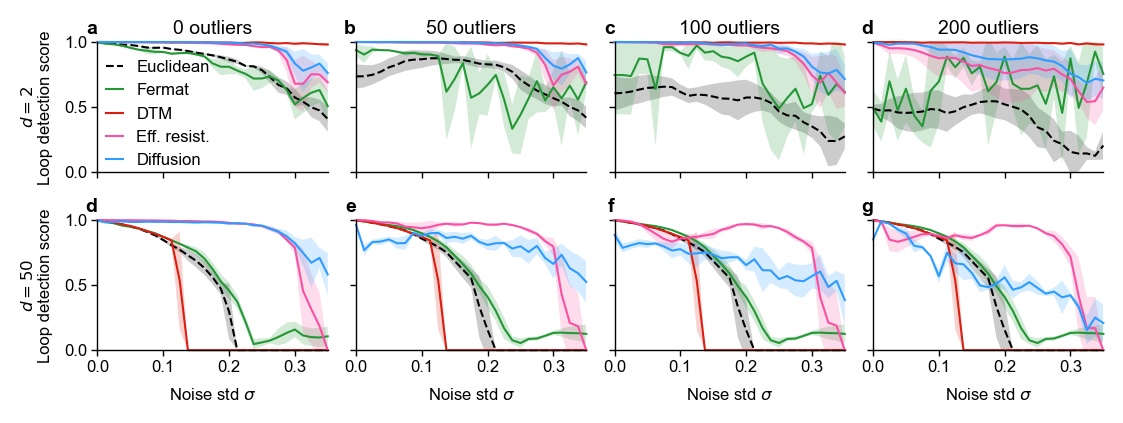

In [17]:
# plot figure
embd_dims_for_plot = [2, 50]
mask = np.ones_like(nbs_outliers, dtype=bool)
nbs_outliers_for_plot = np.array(nbs_outliers)[mask]

fig, ax = plt.subplots(ncols=len(nbs_outliers_for_plot), nrows=len(embd_dims_for_plot), figsize=(5.5, len(embd_dims_for_plot)))

letters = "abcdefghi"

shift = 0
for j, n_outliers in enumerate(nbs_outliers_for_plot):
    if not mask[j]: shift += 1
    for i, embd_dim in enumerate(embd_dims_for_plot):
        for dist in distances:
            full_dist = best_full_dists[embd_dim][dist][j+shift]
            
            mean = outlier_scores[embd_dim][dist][full_dist][j+shift].mean(1)
            std = outlier_scores[embd_dim][dist][full_dist][j+shift].std(1)
            
            if dist != "euclidean":
                ax[i, j].plot(sigmas, 
                           mean,
                           label=dist_to_print[dist],
                           color=dist_to_color[dist],
                           clip_on=False)
                ax[i, j].fill_between(
                    sigmas,
                    mean - std,
                    mean + std,
                    alpha=0.2,
                    color=dist_to_color[dist],
                    edgecolor=None,
                )
                
            else:
                ax[i, j].plot(sigmas, 
                              mean,
                              label=dist_to_print[dist],
                              color=dist_to_color[dist],
                              clip_on=False,
                              linestyle="dashed")
                ax[i, j].fill_between(
                    sigmas,
                    mean - std,
                    mean + std,
                    alpha=0.2,
                    color=dist_to_color[dist],
                    edgecolor=None,
                )   
        if i == 0:
            ax[i, j].set_title(f"{n_outliers} outliers")
        
        ax[i, j].set_title(
            letters[3*i+j],
            loc="left",
            ha="right",
            fontweight="bold",
        ) 
        
        ax[i, j].set_xticks([0, 0.1, 0.2, 0.3])            
    
        ax[i, j].set_ylim(0, 1)

        if i==0:
            ax[i, j].set_xticklabels([])
        else:
            ax[i, j].set_xlabel("Noise std $\sigma$")
        
        if j==0:
            if i < 2:
                ax[i, j].set_ylabel(f"$d={embd_dim}$\nLoop detection score")
            else:
                ax[i, j].set_ylabel(f"$d={embd_dim}$ (no thresholding)\nLoop detection score")
        else:
            ax[i, j].set_yticklabels([])
        if j == 0 and i==0:
            ax[i, j].legend(loc=(.01, -0.02), handlelength=1)
        ax[i, j].set_ylim(0, 1)
        ax[i, j].set_xlim(0, 0.35)
    #fig.suptitle(f"Toy Circle {embd_dim}D", y=1.05)
fig.savefig(os.path.join(fig_path, f"toy_circle_outliers.pdf"))

In [46]:
# check that DTM results are independent of the number of outliers
print(best_full_dists[50]["dtm"])

['dtm_k_4_p_dtm_2_p_radius_1' 'dtm_k_4_p_dtm_2_p_radius_1'
 'dtm_k_4_p_dtm_2_p_radius_1' 'dtm_k_4_p_dtm_2_p_radius_1']
['dtm_k_100_p_dtm_2_p_radius_2' 'dtm_k_100_p_dtm_2_p_radius_2'
 'dtm_k_100_p_dtm_2_p_radius_2' 'dtm_k_100_p_dtm_2_p_radius_2']


In [59]:
print(np.all(outlier_scores[50]["dtm"]["dtm_k_4_p_dtm_2_p_radius_1"][0] == outlier_scores[50]["dtm"]["dtm_k_4_p_dtm_2_p_radius_1"][1]))
print(np.all(outlier_scores[50]["dtm"]["dtm_k_4_p_dtm_2_p_radius_1"][0] == outlier_scores[50]["dtm"]["dtm_k_4_p_dtm_2_p_radius_1"][2]))
print(np.all(outlier_scores[50]["dtm"]["dtm_k_4_p_dtm_2_p_radius_1"][0] == outlier_scores[50]["dtm"]["dtm_k_4_p_dtm_2_p_radius_1"][3]))


True
True
True
